In [ ]:
!pip install pandas numpy networkx scikit-learn sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load your merged CSV file
df = pd.read_csv("All_Poems_Originality_Scored.csv")

# Separate human and LLM poems
df_llm = df[df["Source"] != "Human"].reset_index(drop=True)
df_human = df[df["Source"] == "Human"].reset_index(drop=True)

# Load MiniLM model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode embeddings
human_embeddings = model.encode(df_human["Poem"].tolist(), normalize_embeddings=True)
llm_embeddings = model.encode(df_llm["Poem"].tolist(), normalize_embeddings=True)

# Compute cosine similarity
similarity_matrix = cosine_similarity(llm_embeddings, human_embeddings)

# Build graph with top-k similarity edges
G = nx.DiGraph()
top_k = 3  # connect each LLM poem to top 3 most similar human poems

for i, row in df_human.iterrows():
    G.add_node(f"human_{i}", label=row["Title"], type="human", category=row["Category"])

for i, row in df_llm.iterrows():
    G.add_node(f"llm_{i}", label=row["Title"], type="llm", category=row["Category"], source=row["Source"])

    # Find top-k most similar human poems
    top_k_indices = np.argsort(similarity_matrix[i])[::-1][:top_k]
    top_k_sims = similarity_matrix[i][top_k_indices]

    for j, sim in zip(top_k_indices, top_k_sims):
        G.add_edge(f"human_{j}", f"llm_{i}", weight=sim)

    # Creativity = 1 - max similarity from top-k
    max_sim = max(top_k_sims, default=0)
    df_llm.at[i, "Graph-Based Creativity Score"] = round(1 - max_sim, 3)

# Save output
df_llm.to_csv("LLM_Poems_Creativity_Scored_topk.csv", index=False)
print("Creativity scores saved to LLM_Poems_Creativity_Scored_topk.csv")


Creativity scores saved to LLM_Poems_Creativity_Scored_topk.csv


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load your merged CSV file
df = pd.read_csv("All_Poems_Originality_Scored.csv")

# Separate human and LLM poems
df_llm = df[df["Source"] != "Human"].reset_index(drop=True)
df_human = df[df["Source"] == "Human"].reset_index(drop=True)

# Load MiniLM model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode embeddings
human_embeddings = model.encode(df_human["Poem"].tolist(), normalize_embeddings=True)
llm_embeddings = model.encode(df_llm["Poem"].tolist(), normalize_embeddings=True)

# Compute cosine similarity
similarity_matrix = cosine_similarity(llm_embeddings, human_embeddings)

# Construct graph and compute creativity scores
G = nx.DiGraph()
top_k = 5  # Number of human poems to connect to each LLM poem

# Add human nodes
for i, row in df_human.iterrows():
    G.add_node(f"human_{i}", label=row["Title"], type="human", category=row["Category"])

# Add LLM nodes and edges
for i, row in df_llm.iterrows():
    G.add_node(f"llm_{i}", label=row["Title"], type="llm", category=row["Category"], source=row["Source"])

    # Top-k most similar human poems
    top_k_indices = np.argsort(similarity_matrix[i])[::-1][:top_k]
    top_k_sims = similarity_matrix[i][top_k_indices]

    # Add edges from top-k humans
    for j, sim in zip(top_k_indices, top_k_sims):
        G.add_edge(f"human_{j}", f"llm_{i}", weight=sim)

    # Creativity = 1 - average similarity → rescaled to 1–10
    avg_sim = np.mean(top_k_sims)
    graph_score = 1 - avg_sim
    creativity_1to10 = round(1 + graph_score * 9, 2)

    # Save score
    df_llm.at[i, "Graph-Based Creativity Score (1–10)"] = creativity_1to10

# Save output
df_llm.to_csv("LLM_Poems_Creativity_Scored_AvgSim_1to10.csv", index=False)
print("Creativity scores saved to LLM_Poems_Creativity_Scored_AvgSim_1to10.csv")


Creativity scores saved to LLM_Poems_Creativity_Scored_AvgSim_1to10.csv


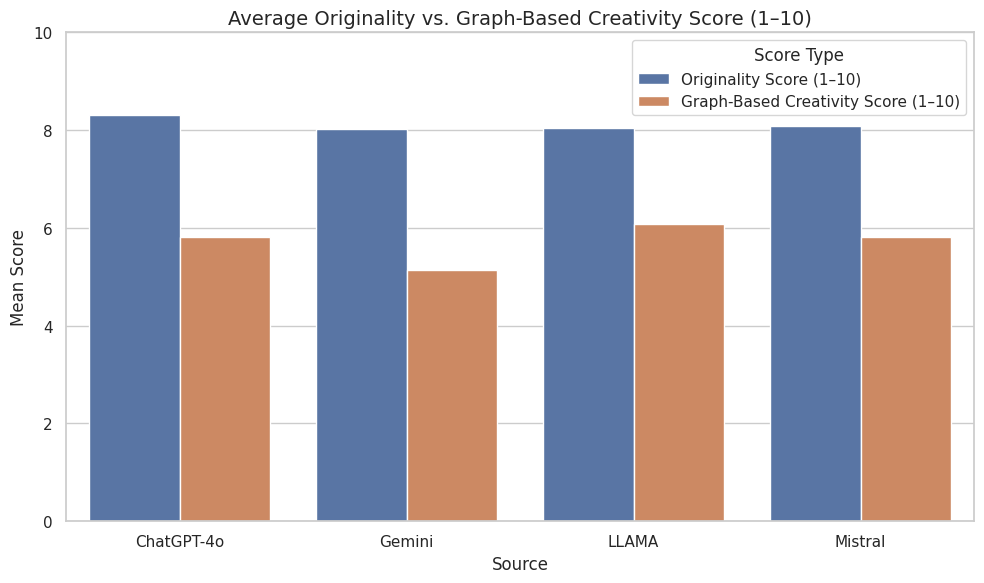

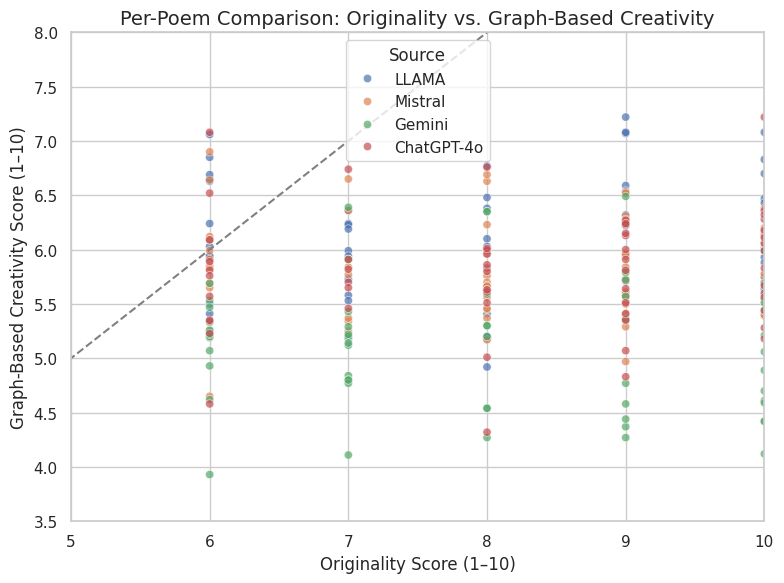

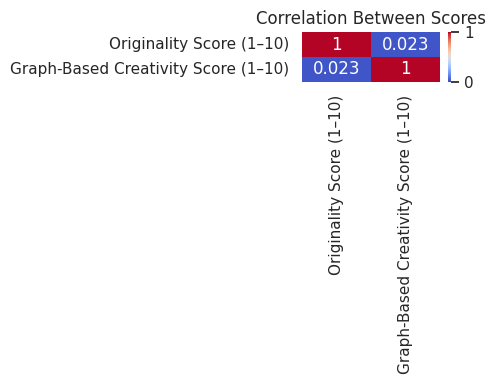

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the final scored data
df = pd.read_csv("LLM_Poems_Creativity_Scored_AvgSim_1to10.csv")

# Set plot style
sns.set(style="whitegrid")

# -------------------------------
# 1. Barplot: Mean Score per Model
# -------------------------------
plt.figure(figsize=(10, 6))
score_summary = df.groupby("Source")[["Originality Score (1–10)", "Graph-Based Creativity Score (1–10)"]].mean().reset_index()
score_summary = pd.melt(score_summary, id_vars="Source", var_name="Metric", value_name="Score")

sns.barplot(data=score_summary, x="Source", y="Score", hue="Metric")
plt.title("Average Originality vs. Graph-Based Creativity Score (1–10)", fontsize=14)
plt.ylabel("Mean Score")
plt.ylim(0, 10)
plt.legend(title="Score Type")
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Scatterplot: Per-Poem Comparison
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Originality Score (1–10)", y="Graph-Based Creativity Score (1–10)", hue="Source", alpha=0.7)
plt.title("Per-Poem Comparison: Originality vs. Graph-Based Creativity", fontsize=14)
plt.plot([0, 10], [0, 10], '--', color='gray')  # reference line y=x
plt.xlim(5, 10)
plt.ylim(3.5, 8)
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Correlation Matrix
# -------------------------------
correlation = df[["Originality Score (1–10)", "Graph-Based Creativity Score (1–10)"]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Between Scores")
plt.tight_layout()
plt.show()
